# Project - Recommendation Systems 

### Data Description: <br>
Amazon Reviews data (data source) The repository has several datasets. For this
case study, we are using the Electronics dataset.

### Context: <br>
Online E-commerce websites like Amazon, Flipkart uses different
recommendation models to provide different suggestions to different users.
Amazon currently uses item-to-item collaborative filtering, which scales to
massive data sets and produces high-quality recommendations in real-time.

### Attribute Information: <br>
● userId : Every user identified with a unique id <br>
● productId : Every product identified with a unique id <br>
● Rating : Rating of the corresponding product by the corresponding user <br>
● timestamp : Time of the rating (we will ignore this) <br>

### Objective: <br>
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

In [1]:
#Importing standard Libraries for EDA & visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Importing Surprise library for data spliting, model building and for accuracy
from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

#Importing time for tracking computational times
import time

In [3]:
# Reading dataset, naming headers as they are not present in the dataset
df = pd.read_csv("ratings.csv", names=["userId", "productId", "rating", "timestamp"])  
df.head() 

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#Shape of the data
print("The dataframe has {} rows and {} columns".format(df.shape[0],df.shape[1]))

The dataframe has 7824482 rows and 4 columns


In [5]:
#Attribute information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


User Id and Product Id are objects where as rating feature is a float.

In [6]:
#fucntion to check how many null values are there
df.apply(lambda x: sum(x.isnull()))

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [7]:
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [8]:
df.isna().any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

No null values detected. 

In [9]:
unique_userId = df['userId'].nunique()
unique_productId = df['productId'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  4201696
Total number of unique Products :  476002


In [10]:
#5 point summary of the dataframe
df_transpose = df.describe().T
df_transpose

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


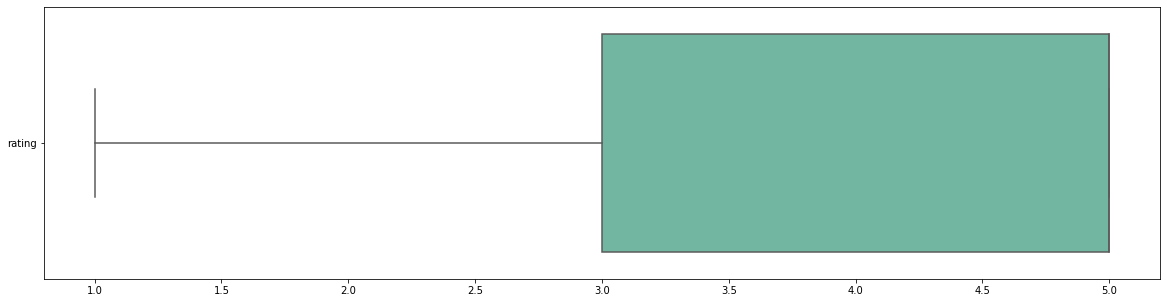

In [52]:
#Checking for outliers visually using box plot

plt.figure(figsize=(20,5))
sns.boxplot(data=df, orient='h', palette='Set2', dodge=False)

There are no outliers observed in the ratings feature

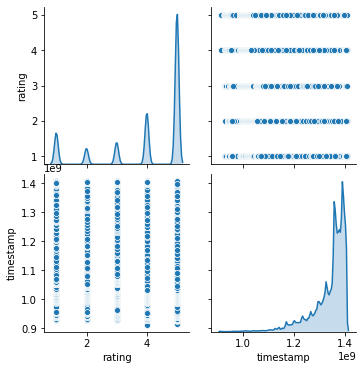

In [12]:
#Pair plot
sns.pairplot(df, diag_kind= 'kde')

It can be observed that 5 rating is a tall tower whereas others do not compare much. 2 and 3 ratings are the lowest frequency.

In [13]:
# Checking the count ratio of the ratings
df['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

In [14]:
rating_counts = pd.DataFrame(df['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,5.0,4347541
1,4.0,1485781
2,1.0,901765
3,3.0,633073
4,2.0,456322


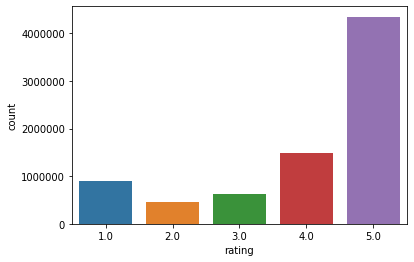

In [15]:
#Visualizing the spread of ratings in terms of count
sns.countplot(df['rating'])

It is clear that 5 is the most frequent rating. 

In [16]:
df.corr()

,rating,timestamp
rating,1.000000,0.041648
timestamp,0.041648,1.000000


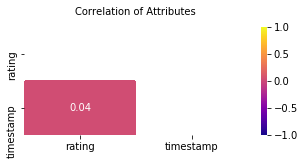

In [17]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,2))
plt.title('Correlation of Attributes', y=1.05, size=10)
sns.heatmap(df.corr(),vmin=-1, cmap='plasma',annot=True,  mask=mask, fmt='.2f')

There is not much information and insight to be gained with correlating ratings and timestamp.

In [18]:
#Dropping timestamp
df = df.drop(['timestamp'], axis=1)

In [19]:
#Copying dataframe before inculcating further changes
df1 = df.copy()

In [20]:
df1.head()

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Making subset of the users who've given 50+ ratings to make the dataset less sparse/dense

In [21]:
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),
                                left_on='userId',
                                right_index=True)

In [22]:
subset_df = users_data[users_data.users_counts >= 50]
subset_df.head()

,userId,productId,rating,users_counts
94,A3BY5KCNQZXV5U,0594451647,5.0,50
14863,A3BY5KCNQZXV5U,B00000JD4V,4.0,50
134213,A3BY5KCNQZXV5U,B000063574,5.0,50
338368,A3BY5KCNQZXV5U,B0000CDJP8,5.0,50
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50


### Making subset of the products which have received 10+ ratings

In [23]:
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='productId',
                                right_index=True)

In [24]:
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data.head()

,userId,productId,rating,users_counts,product_rating_counts
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0,50,18
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0,192,18
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0,98,18
634073,A1ZM846Y7AUYD,B0007Y794O,4.0,77,18
633998,A2ED50E3KWKUKW,B0007Y794O,5.0,65,18


This is done to ensure that items which have received only a handful of 5 star ratings do not influence the top recommended items rated by many more users. 

In [25]:
amazon_df = product_rating_data.copy()

In [26]:
panda_data = amazon_df.drop(['users_counts', 'product_rating_counts'], axis=1)

In [27]:
panda_data.head()

,userId,productId,rating
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0


### Spliting the data randomly into train and test ( 70 - 30 split) dataset

In [28]:
#To Get top - K ( K = 5)
k = 5

In [29]:
#We must define a Reader object for the Surprise package to parse the dataframe.
reader = Reader(rating_scale=(1, 5))

In [30]:
surprise_data = Dataset.load_from_df(panda_data[['userId', 'productId', 'rating']], reader)

In [31]:
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)

### Building Popularity Recommender model

**Using mean of products rating**:

In [32]:
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [33]:
panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00006HSML    5.0
B001TH7GUA    5.0
B000IJY8DS    5.0
B005LDLP8W    5.0
Name: rating, dtype: float64

In [34]:
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())
prod_rating_count.head(k)

,rating,prod_rating_count
productId,,
B00L3YHF6O,5.0,14
B00006HSML,5.0,10
B001TH7GUA,5.0,17
B000IJY8DS,5.0,17
B005LDLP8W,5.0,16


In [35]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)
basic_poplurity_model.head(k)

,rating,prod_rating_count
productId,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


**This is the list of top 5 popular products.**

**Using Ranking Based Algorithm**:

In [36]:
#Count of user_id for each unique song as recommendation score 
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped.head()

,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [37]:
#Sort on recommendation score 
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = panda_data_sort.head(k) 
popularity_recommendations 

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0


In [38]:
# UsINNG popularity based recommender model to make predictions
import warnings
warnings.filterwarnings('ignore')
def recommend(userId):     
    user_recommendations = popularity_recommendations 
          
    #Adding user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = userId 
      
    #Bringing user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [39]:
find_recom = [15,121,55,230,344]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

      userID   productId  score  Rank
1592      15  B0088CJT4U    206   1.0
839       15  B003ES5ZUU    184   2.0
226       15  B000N99BBC    167   3.0
1552      15  B007WTAJTO    164   4.0
1577      15  B00829TIEK    149   5.0


Here is the recommendation for the userId: 121

      userID   productId  score  Rank
1592     121  B0088CJT4U    206   1.0
839      121  B003ES5ZUU    184   2.0
226      121  B000N99BBC    167   3.0
1552     121  B007WTAJTO    164   4.0
1577     121  B00829TIEK    149   5.0


Here is the recommendation for the userId: 55

      userID   productId  score  Rank
1592      55  B0088CJT4U    206   1.0
839       55  B003ES5ZUU    184   2.0
226       55  B000N99BBC    167   3.0
1552      55  B007WTAJTO    164   4.0
1577      55  B00829TIEK    149   5.0


Here is the recommendation for the userId: 230

      userID   productId  score  Rank
1592     230  B0088CJT4U    206   1.0
839      230  B003ES5ZUU    184   2.0
226   

Top 5 popular products for all users is the same as this is the popularity based model. There is no personalization for any particular user. 

### Collaborative Filtering Model:

In [40]:
cv_results = []  # to store cross validation result 

Here Grid Search is used to find the best hyper parameters for running SVD. These will be passed to the algorithm for optimal results.

In [54]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])

0.8711132486965456
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [42]:
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8728  0.8836  0.8590  0.8697  0.8868  0.8744  0.0100  
MAE (testset)     0.6453  0.6521  0.6377  0.6467  0.6502  0.6464  0.0050  
Fit time          2.27    2.25    2.26    2.27    2.25    2.26    0.01    
Test time         0.07    0.07    0.08    0.07    0.07    0.07    0.00    


==================== Model Evaluation ===============================
RMSE: 0.8808

 Computational Time : 14.199s


,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.874359,0.646408,2.261939,0.068426


Here we can see that the RMSE of testset and complete dataset found from cross_validation. The test and training sets and performing similarly well. 

### K-NN Based Algorithms

Using grid search to find out the best hyper parameters for KNNBasic, KNNWithMeans and KNNWithZScore Algorithm.

In [43]:
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

0.9633477318225742
0.9180681342753763
0.9227086402332481
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}

Computational Time : 856.301s


**KNNBasic**

In [44]:
start_time = time.time()

# Creating Model using best parameters
knnBasic_model = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], 
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9737  0.9865  0.9820  0.9817  0.9878  0.9823  0.0049  
MAE (testset)     0.6904  0.6995  0.6951  0.6989  0.7009  0.6970  0.0038  
Fit time          0.79    0.79    0.78    0.76    0.79    0.78    0.01    
Test time         0.53    0.46    0.43    0.44    0.42    0.45    0.04    


==================== Model Evaluation ===============================
RMSE: 1.0018

 Computational Time : 7.

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.874359,0.646408,2.261939,0.068426
1,KNNBasic,0.982343,0.696966,0.780756,0.454633


**KNNWithZScore**

In [45]:
start_time = time.time()

# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], 
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9326  0.9286  0.9316  0.9462  0.9317  0.9342  0.0062  
MAE (testset)     0.6465  0.6461  0.6487  0.6630  0.6500  0.6508  0.0062  
Fit time          0.87    0.90    0.88    0.88    0.89    0.88    0.01    
Test time         0.51    0.49    0.50    0.54    0.55    0.52    0.02    


==================== Model Evaluation ===============================
RMSE: 0.9541

 Computational Time

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.874359,0.646408,2.261939,0.068426
1,KNNBasic,0.982343,0.696966,0.780756,0.454633
2,KNNWithZScore,0.934171,0.650830,0.884434,0.518242


**KNNWithMeans User-User**

In [46]:
start_time = time.time()

# Creating Model using best parameters
knnMeansUU_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(trainset)

# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], 
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansUU, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9184  0.9082  0.9148  0.9065  0.9190  0.9134  0.0052  
MAE (testset)     0.6485  0.6376  0.6442  0.6317  0.6456  0.6415  0.0061  
Fit time          0.48    0.49    0.48    0.51    0.56    0.51    0.03    
Test time         0.34    0.36    0.33    0.40    0.35    0.35    0.02    


==================== Model Evaluation ===============================
RMSE: 0.9364

 Computational Time 

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.874359,0.646408,2.261939,0.068426
1,KNNBasic,0.982343,0.696966,0.780756,0.454633
2,KNNWithZScore,0.934171,0.650830,0.884434,0.518242
3,KNNWithMeans User-User,0.913399,0.641534,0.505460,0.354468


**KNNWithMeans Item-Item**

In [47]:
start_time = time.time()

# Creating Model using best parameters
knnMeansII_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnMeansII_model.fit(trainset)

# Predicting for testset
prediction_knnMeansII = knnMeansII_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans Item-Item on 5 split(s)
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'], 
                           knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansII_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansII, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9157  0.9196  0.9308  0.9195  0.9272  0.9226  0.0056  
MAE (testset)     0.6456  0.6458  0.6497  0.6490  0.6518  0.6484  0.0024  
Fit time          0.81    0.80    0.80    0.84    0.82    0.81    0.01    
Test time         0.44    0.45    0.46    0.44    0.46    0.45    0.01    


==================== Model Evaluation ===============================
RMSE: 0.9450

 Computational Time 

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.874359,0.646408,2.261939,0.068426
1,KNNBasic,0.982343,0.696966,0.780756,0.454633
2,KNNWithZScore,0.934171,0.650830,0.884434,0.518242
3,KNNWithMeans User-User,0.913399,0.641534,0.505460,0.354468
4,KNNWithMeans Item-Item,0.922559,0.648358,0.813021,0.451394


### Comparing all algorithms 

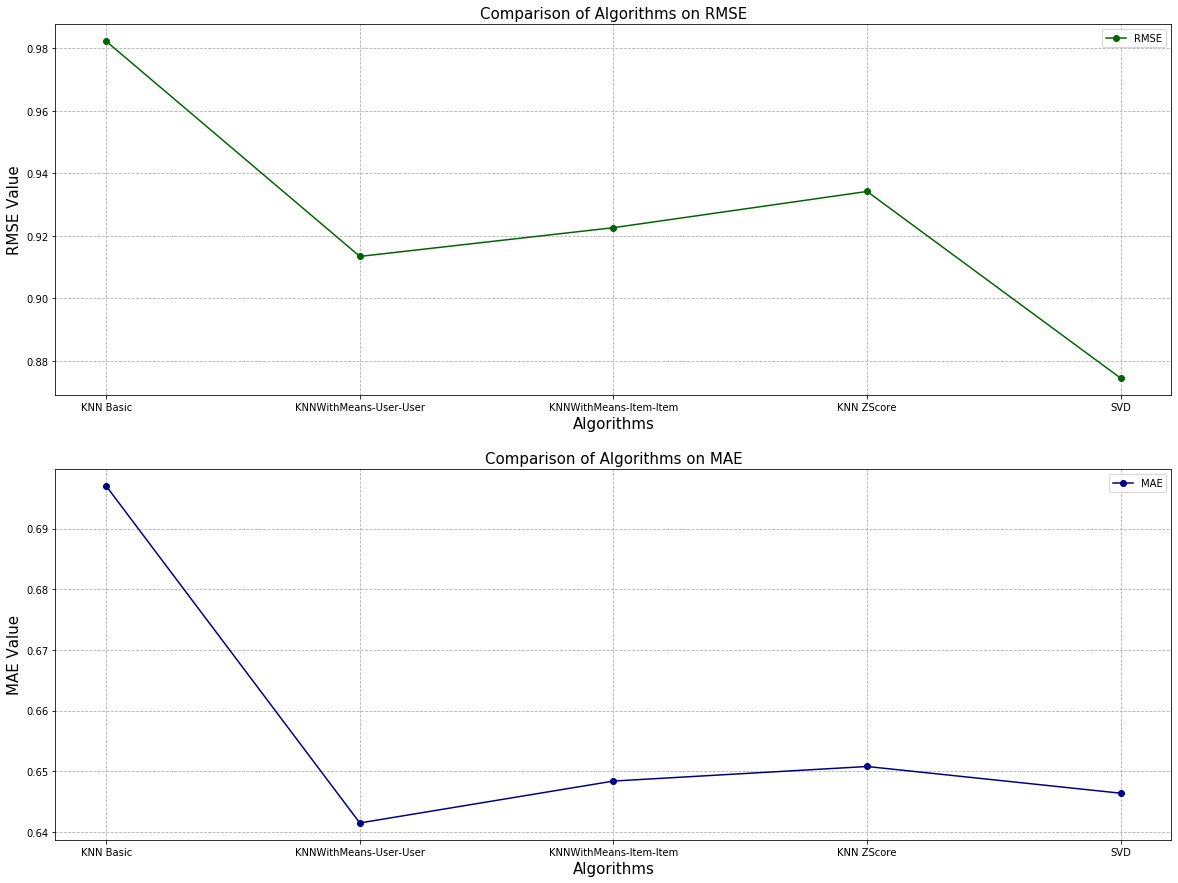

,Model,RMSE,MAE,Fit Time,Test Time
0,SVD,0.874359,0.646408,2.261939,0.068426
1,KNNBasic,0.982343,0.696966,0.780756,0.454633
2,KNNWithZScore,0.934171,0.650830,0.884434,0.518242
3,KNNWithMeans User-User,0.913399,0.641534,0.505460,0.354468
4,KNNWithMeans Item-Item,0.922559,0.648358,0.813021,0.451394


In [48]:
x_algo = ['KNN Basic', 'KNNWithMeans-User-User', 'KNNWithMeans-Item-Item', 'KNN ZScore', 'SVD']
all_algos_cv = [knnBasic_cv, knnMeansUU_cv, knnMeansII_cv, knnZscore_cv, svd_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,15))

plt.subplot(2, 1, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(2, 1, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

cv_results

It can be seen that SVD is giving the best RMSE value and KNNWithMeans(User-User) is giving best MAE value.

### Top - K ( K = 5) recommendations

In [49]:
top_n = defaultdict(list)
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k (highest).
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=k)
top_n

defaultdict(list,
            {'AZBXKUH4AIW3X': [('B0058UUR6E', 4.7715394220066525),
              ('B00316263Y', 4.688789087043816),
              ('B008EQZ25K', 4.645982486744961),
              ('B005LDLP8W', 4.590498429818668),
              ('B000BSN4UY', 4.587878291706512)],
             'A1T1YSCDW0PD25': [('B004S4R5CK', 4.8770736040869815),
              ('B0099SMFVQ', 4.816562577003621),
              ('B0002SQ2P2', 4.805867105558767),
              ('B000AZ57M6', 4.764120244400831),
              ('B000CKVOOY', 4.708950089797007)],
             'A1HYH206E18XVC': [('B006EKIQYM', 4.552460028662889),
              ('B00CE590Z0', 4.2506620151665615),
              ('B005DM9BGE', 4.250142025046474),
              ('B003YKG2UK', 4.192136882383182),
              ('B002VPE1XY', 4.136244985856913)],
             'A2ZFFSJ0VM6KSJ': [('B00AAIPT76', 4.868534570841069),
              ('B008AST7R6', 4.747034643024721),
              ('B005DOK8NW', 4.737548537552402),
              ('B007I5J

It can be seen that the model is recommending upto 5 items to each user. There are some cases where recommendations are less that 5 due to the reason that the algorithm is unable to find appropriate neighbours.

In conclusion: It was observed that using SVD, we are able to recommend 5 new items to every user based on their habits. Matrix factorization and KNN based algorithms were used to build the Collaborative Filtering Model. As for Popularity Model, it was observed that the same 5 items are recommended to every user based on the ratings of the items irrespective of the personalized history of the user. 